In [1]:
import re
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
node = []
allDatas = []
siganlList = []
SignalsName = []
messageName = []

In [2]:
def readFile(file_name):
    global node,allDatas,siganlList,SignalsName,messageName
    ''' 得到dbc文件的绝对路径'''
    filePath = file_name
    if filePath:
        print(filePath)
        f = open(filePath, "r")  # 设置文件对象
    else:
        print("读取文件失败！")
        return 0
    """
    NodesPattern:节点
    MessagePattern：消息
    SignalPattern：信号
    """
    NodesPattern = re.compile(r"BU_: (.*)", re.S)
    MessagePattern = re.compile(r"BO_ (.*?) (.*?): (.*?) (.*)", re.S)
#     SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@.*? \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@([0-9])([+|-]) \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    DefaultValue = '''BA_ "GenSig(.*?)" SG_ (\d+) signalname (\d+);'''

    line = f.readline()
    allDatas=[]
    while line:
        """ 匹配出节点 """
        NodesSearched = re.search(NodesPattern, line.strip())
        if NodesSearched:
            node = NodesSearched.group(1).split(" ")
            #print(node)
        """ 匹配出消息 """
        MessageSearched = re.search(MessagePattern, line.strip())
        if MessageSearched:
            siganlList.clear()
            """如果匹配到了message，则获取到message的相关参数 
             比如匹配到了NM_Message_ESC_409，则会解析出改message的一些参数构成list对象['1033', 'NM_Message_ESC_409', '8', 'ESC']
             这四个参数分别是 messgage ID ;message name ; messgae dataLenth ,message sender
             而且把这个list对象 加在了 siganlList 索引0的位置
            """
            Message = list(MessageSearched.groups())
            siganlList.append(Message)
            """ 只 要 message的名字 messageName 列表中"""
            messageName.append(Message[1])
            """读取下一行"""
            line = f.readline()
            """因为有些message并没有定义signal，所以 下一行还是message"""
            MessageSearched = re.search(MessagePattern, line.strip())
            SignalSearched = re.search(SignalPattern, line.strip())
            """下一行如果不是message的内容 就一定是signal的内容了"""
            if not MessageSearched:
                while SignalSearched:
                    """获取信号的参数追加到siganlList"""
                    signal = list(SignalSearched.groups())
                    siganlList.append(signal)
                    """只获取 signal name"""
                    SignalsName.append(signal[0])

                    # 再次解析信号，直到这个message下的信号全部解析完毕
                    line = f.readline()
                    SignalSearched = re.search(SignalPattern, line.strip())
           # print(siganlList)
            c = copy.deepcopy(siganlList)
            allDatas.append(c)
        else:
            line = f.readline()
            MessageSearched = re.search(MessagePattern, line.strip())
    f.close()  # 将文件关闭
    return 1

In [3]:
import os
file_names = []
path = os.path.abspath('../My_DBC')
# path = os.path.abspath('../opendbc-master/opendbc-master-delFalseData')
# path = os.path.abspath('./opendbc-master/opendbc-master')
dirs = os.listdir(path)                    # 获取指定路径下的文件
for i in dirs:
    if os.path.splitext(i)[1] == ".dbc":
        file_names.append(os.path.join(path,i))
file_names

['D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_object.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\gm_global_a_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_hatchback_ex_2017_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_sedan_16_diesel_2019_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_touring_2016_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\tesla_can.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\tesla_powertrain.dbc',
 'D:\\--storage-

In [4]:
def get_id_labels(index):
    file_name = file_names[index]
    readFile(file_name)

    # 将DBC文件中的ID(10进制数)改为ID(16进制数)
    data_gts = {}
    for alldata in allDatas:
        data_gts[str(hex(int(alldata[0][0])))[2:]] = alldata

    # 得到DBC文件中各ID Message对应信号位置
    all_id_lsbs = {}
    for k in data_gts.keys():
        message = data_gts[k]
        lsb_list = []
        series = np.zeros(64)
        message_id = message[0][0]+"_"+message[0][1]
        del message[0]
        for signal in message:
            start = int(signal[1])
            length = int(signal[2])
            endianness = int(signal[3])
            start_row = int(start / 8)
            start_col = 8 - (start - start_row * 8) - 1
            new_start = start_row * 8 + start_col
            if endianness == 0:
                new_end = new_start + length
                cur_lsb = new_end - 1
            if endianness == 1:
                cur_lsb = new_start
            lsb_list.append(cur_lsb)
        all_id_lsbs[k] = lsb_list

    # 将各ID Message的信号位置改为 0/1 label
    all_id_labels = {}
    for k in all_id_lsbs:
        cur_lsb_list = all_id_lsbs[k]
        cur_label = np.zeros(64)
        for cur_lsb in cur_lsb_list:
            cur_label[cur_lsb] = 1
        all_id_labels[k] = cur_label
    return all_id_labels

In [5]:
def get_trace(data):
    group = data.groupby(by="ID")
    id_tracedict = {}
    for trace in list(group):
        id_tracedict[trace[0]] = trace[1]["bin"].apply(lambda x: list(x)).apply(lambda x: list(map(int, x))).tolist()
    return id_tracedict

In [6]:
def get_ids(id_tracedict_int, all_id_labels):
    ids = []
    for id in id_tracedict_int.keys():
        if(id_tracedict_int.__contains__(id) and all_id_labels.__contains__(id)):
            ids.append(id)
    return ids

In [7]:
import random
# 设置全局的随机种子
random.seed(100)
# 以id为单位shuffle
def get_train_test_ids(id_tracedict, all_id_labels):
    ids = get_ids(id_tracedict, all_id_labels)
#     random.shuffle(ids)
    ids.sort()
    train_len = int(len(ids)*0.9)
    train_ids = ids[:train_len]
    test_ids = ids[train_len:]
    return train_ids, test_ids

In [8]:
def get_trace_data(id_tracedict_int, all_id_labels): 
    cur_trace_data = []
    cur_trace_label = []
    for id in id_tracedict_int.keys():
        cur_trace = id_tracedict_int[id]
        cur_label = all_id_labels[id]
        length = len(cur_trace)
        start = 4000
        end = start + 1000
        n = int((length-4000)/1000)
        for i in range(n):
            cur_trace_data.append(cur_trace[start: end])
            cur_trace_label.append(cur_label)
            start = end
            end = start + 1000
    return cur_trace_data, cur_trace_label

In [35]:
def get_data_label(id_tracedict_int, all_id_labels):
    cur_trace_data, cur_trace_label = get_trace_data(id_tracedict_int, all_id_labels)
    trace_indexs = pd.DataFrame(cur_trace_label).index.tolist()
    random.shuffle(trace_indexs)
    trace_data, trace_labels = np.array(cur_trace_data)[trace_indexs], np.array(cur_trace_label)[trace_indexs]
    return trace_data, trace_labels

In [36]:
def get_trace_data_dict(cur_ids, id_tracedict_int, all_id_labels, trace_data_dict, trace_label_dict): 
    for id in cur_ids:
        trace_data_dict[id] = id_tracedict_int[id]
        trace_label_dict[id] = all_id_labels[id]

In [78]:
# 合并所有Cadillac以及Chevy车的Ground Truth的 0/1 label
dict0 = get_id_labels(0)
dict1 = get_id_labels(1)
dict2 = get_id_labels(2)
cadillac_id_labels = dict()
for key in dict0.keys() | dict1.keys() | dict2.keys():
    for d in (dict0, dict1, dict2):
        if d.__contains__(key):
            cadillac_id_labels[key] = d[key]
            break

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\cadillac_ct6_object.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\cadillac_ct6_powertrain.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\gm_global_a_powertrain.dbc


In [79]:
# 合并所有Honda车的Ground Truth的 0/1 label
dict3 = get_id_labels(3)
dict4 = get_id_labels(4)
dict5 = get_id_labels(5)
honda_id_labels = dict()
for key in dict3.keys() | dict4.keys() | dict5.keys():
    for d in (dict3, dict4, dict5):
        if d.__contains__(key):
            honda_id_labels[key] = d[key]
            break

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_hatchback_ex_2017_can_generated.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_sedan_16_diesel_2019_can_generated.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_touring_2016_can_generated.dbc


In [13]:
# 得到Honda车的子数据集数据
data_hd_1 = pd.read_csv('../Data/Honda/honda001.csv')
data_hd_2 = pd.read_csv('../Data/Honda/honda002.csv')
data_hd = pd.concat([data_hd_1,data_hd_2])
# data_hd_3 = pd.read_csv('../Data/Honda/honda003.csv')
# data_hd = pd.concat([data_hd_1,data_hd_2,data_hd_3])
# data_hd = pd.read_csv('../Data/Honda/honda001.csv')
# data_hd = pd.read_csv('../Data/Honda/honda001.csv')
data_hd["bin"] = data_hd["Data"].apply(int, base=16).apply(bin).str[2:].apply(lambda x: x.zfill(64))

# 得到Honda车子的数据集的大Trace dict
id_tracedict_hd = get_trace(data_hd)

In [80]:
honda_id_labels.keys()

dict_keys(['18f', '305', '1ea', '200', '244', '405', '1ef', 'e4', '241', '14a', '1e7', '17c', '1d0', '296', '1ed', '247', '13c', '243', '309', '33d', 'e5', '240', '246', '37b', '37c', '191', '1fa', '1a4', '201', '30c', '94', '1c2', '158', '39f', '374', 'e8', '1a3', '24a', '130', '516', '249', '324', '1ab', '1df', '221', '255', '326', '1b0', '35e'])

In [81]:
# 得到用于训练和测试的id
train_ids_hd, test_ids_hd = get_train_test_ids(id_tracedict_hd, honda_id_labels)

In [15]:
# 得到Cadillac车的子数据集数据
data_cd_1 = pd.read_csv('../Data/Cadillac/CadillacCSV/001.txt.csv')
data_cd_2 = pd.read_csv('../Data/Cadillac/CadillacCSV/002.txt.csv')
# data_cd_3 = pd.read_csv('../Data/Cadillac/CadillacCSV/003.txt.csv')
# data_cd = pd.concat([data_cd_1,data_cd_2,data_cd_3])
data_cd = pd.concat([data_cd_1,data_cd_2])
# data_cd = pd.read_csv('../Data/Cadillac/CadillacCSV/001.txt.csv')
data_cd["bin"] = data_cd["Data"].apply(int, base=16).apply(bin).str[2:].apply(lambda x: x.zfill(64))

# 得到Honda车子的数据集的大Trace dict
id_tracedict_cd = get_trace(data_cd)

In [82]:
# 得到用于训练和测试的id
train_ids_cd, test_ids_cd = get_train_test_ids(id_tracedict_cd, cadillac_id_labels)

In [83]:
# 得到honda和caddilac车的trace dict及对应的label dict
train_data_dict = {}
train_label_dict = {}
get_trace_data_dict(train_ids_hd, id_tracedict_hd, honda_id_labels, train_data_dict, train_label_dict)
get_trace_data_dict(train_ids_cd, id_tracedict_cd, cadillac_id_labels, train_data_dict, train_label_dict)

test_data_dict = {}
test_label_dict = {}
get_trace_data_dict(test_ids_hd, id_tracedict_hd, honda_id_labels, test_data_dict, test_label_dict)
get_trace_data_dict(test_ids_cd, id_tracedict_cd, cadillac_id_labels, test_data_dict, test_label_dict)

In [84]:
# shuffle后得到训练集和测试集
train_data, train_labels = get_data_label(train_data_dict, train_label_dict)

In [86]:
test_data, test_labels = get_data_label(test_data_dict, test_label_dict)

In [85]:
test_data_dict.keys()

dict_keys(['374', '405', '787', 'be', 'c9', 'd1', 'f1'])

In [20]:
# 使用READ方法计算bit-flip
def get_bit_Flips(cur_id_traces):
    bit_Flips = []
    for i in range(len(cur_id_traces)):
        bit_Flips.append(get_one_trace_bit_Flips(cur_id_traces[i]))
    return bit_Flips

In [21]:
# 使用READ方法计算bit-flip
def get_one_trace_bit_Flips(cur_id_traces):
    messagelist = cur_id_traces
    trace_len = len(messagelist)
    bit_flip = np.zeros(64)
    previous = messagelist[0]
    for item in messagelist:
        for ix in range(64):
            if item[ix] != previous[ix]:
                bit_flip[ix] = bit_flip[ix] + 1
        previous = item
    for ix in range(64):
        bit_flip[ix] = bit_flip[ix] / trace_len
    return bit_flip

In [1]:
import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Input, Permute, BatchNormalization, Flatten, MaxPooling1D, Conv1D,Conv2D, MaxPooling2D
from keras.layers import concatenate, add
from keras.losses import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
import keras.backend as K
from sklearn import metrics
from keras.callbacks import Callback
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a f

## 模型调参

1. 首先对Model进行一次调参运行
    + 对Model3，先跑一遍acc，再尝试f1-score
2. 研究直接对bit-flip进行分类
3. 研究上述两种过程的结合和调参
4. 考虑Transformer，及各种优化

In [26]:
def my_acc(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return sklearn.metrics,f1_score(y_true, y_pred)
# keras.layers.normalization.BatchNormalization(epsilon=1e-06, mode=0, axis=-1, momentum=0.9, weights=None, beta_init='zero', gamma_init='one')
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [23]:
inputs = Input(shape = (1000,64,1))
x = keras.layers.Conv2D(15, 3, padding='same', data_format='channels_last')(inputs)
# x = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(64, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
keras.optimizers.Adam(lr=1e-4)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[my_acc])
model.summary()

NameError: name 'Input' is not defined

In [22]:
# model.save("./Model/My_model/temp.h5")
# model = load_model("./Model/My_model/temp.h5")

In [43]:
train_data_4 = np.expand_dims(train_data, 3)

In [44]:
# model.fit(train_data_4, train_labels,epochs=3, batch_size=5)

In [45]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='acc',
        patience=6,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='./Model/My_model/my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    )
]
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_data_4, train_labels,
     epochs=20,
     batch_size=10,
     callbacks=callbacks_list,
     validation_split=0.1)

Train on 1721 samples, validate on 192 samples
Epoch 1/30
1721/1721 [==============================] - 19s 11ms/step - loss: 0.1256 - acc: 0.9576 - val_loss: 0.0638 - val_acc: 0.9797
Epoch 2/30
1721/1721 [==============================] - 17s 10ms/step - loss: 0.0380 - acc: 0.9893 - val_loss: 0.0199 - val_acc: 0.9946
Epoch 3/30
1721/1721 [==============================] - 15s 9ms/step - loss: 0.0169 - acc: 0.9949 - val_loss: 0.0092 - val_acc: 0.9977
Epoch 4/30
1721/1721 [==============================] - 15s 9ms/step - loss: 0.0089 - acc: 0.9973 - val_loss: 0.0037 - val_acc: 0.9989
Epoch 5/30
1721/1721 [==============================] - 15s 9ms/step - loss: 0.0057 - acc: 0.9983 - val_loss: 0.0025 - val_acc: 0.9991
Epoch 6/30
1721/1721 [==============================] - 15s 9ms/step - loss: 0.0039 - acc: 0.9987 - val_loss: 0.0013 - val_acc: 0.9996
Epoch 7/30
1721/1721 [==============================] - 14s 8ms/step - loss: 0.0028 - acc: 0.9991 - val_loss: 0.0015 - val_acc: 0.9994
Epoch 

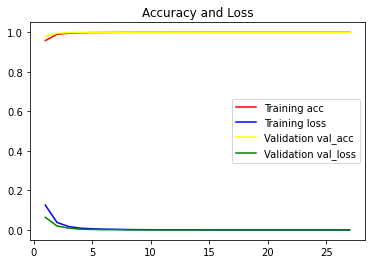

In [46]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']                                                                                                                                                                                                                                                                                                                                                                                                                 oss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
 
plt.title('Accuracy and Loss')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_acc, 'yellow', label='Validation val_acc')
plt.plot(epochs, val_loss, 'green', label='Validation val_loss')
plt.legend()
plt.show()

In [48]:
# model = load_model('my_model.h5')

In [49]:
test_data_4 = np.expand_dims(test_data, 3)

In [50]:
print("训练集:")
predict_target_msb_prob = model.predict(train_data_4)
predict_target_msb_label = (predict_target_msb_prob > 0.5).astype(int)
predict_target_msb_1D = predict_target_msb_label.flatten()
train_labels_1D = train_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_1D == train_labels_1D),len(train_labels_1D))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels_1D,predict_target_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels_1D,predict_target_msb_1D))

print("测试集:")
predict_target_test_msb_prob =model.predict(test_data_4)
predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
test_labels_1D = test_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

训练集:
预测正确数量,训练集样本量:
122428 122432
训练集精确度等指标：
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    113668
         1.0       1.00      1.00      1.00      8764

    accuracy                           1.00    122432
   macro avg       1.00      1.00      1.00    122432
weighted avg       1.00      1.00      1.00    122432

混淆矩阵：
[[113666      2]
 [     2   8762]]
测试集:
预测正确数量,训练集样本量:
12823 13952
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96     13080
         1.0       0.36      0.39      0.38       872

    accuracy                           0.92     13952
   macro avg       0.66      0.67      0.67     13952
weighted avg       0.92      0.92      0.92     13952

混淆矩阵：
[[12482   598]
 [  531   341]]


In [51]:
def get_boundary_score(y_true, y_pred):
    new_labels = []
    new_preds = []
    for i in range(len(y_true)):
        if(y_true[i] == 1):
            new_labels.append(y_true[i])
            new_preds.append(y_pred[i])
    return np.array(new_labels), np.array(new_preds)

In [52]:
new_labels, new_preds = get_boundary_score(test_labels_1D, predict_target_test_msb_1D)
print("预测正确数量,训练集样本量:")
print(sum(new_preds == new_labels),len(new_labels))
print("测试集精确度等指标：")
print(metrics.classification_report(new_labels,new_preds))
print("混淆矩阵：")
print(metrics.confusion_matrix(new_labels,new_preds))

预测正确数量,训练集样本量:
341 872
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.39      0.56       872

    accuracy                           0.39       872
   macro avg       0.50      0.20      0.28       872
weighted avg       1.00      0.39      0.56       872

混淆矩阵：
[[  0   0]
 [531 341]]


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with 

### 1.改进模型一：修改conv

In [31]:
train_data.shape

(1913, 1000, 64)

In [112]:
#绝对准确率
def acc(y_true, y_pred):
    epsilon = 1.e-7
    y_true = tf.compat.v1.cast(y_true, tf.float32)
    y_pred = tf.round(tf.compat.v1.clip_by_value(y_pred, epsilon, 1. - epsilon))
    y_judges = tf.reduce_all(tf.equal(y_true, y_pred),1)
    y_onehot = tf.where(y_judges, tf.ones_like(y_judges), tf.zeros_like(y_judges))
    true_num = tf.compat.v1.count_nonzero(y_onehot)
    all_num = tf.compat.v1.count_nonzero(tf.ones_like(y_onehot))
    acc = true_num/all_num
    return acc

In [130]:
#多标签版本
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np

def KerasFocalLoss(Num):#Num为样本数量
    
    gamma = 2.
    W = 1/np.log(Num)
    W = tf.cast(W, tf.float32)
#     W = tf.transpose(W)
    print(W.shape)
    def FocalLoss(target, input):
        input = tf.cast(input, tf.float32)
        max_val = K.clip(-input, 0, 1)
        loss = input - input * target + max_val + K.log(K.exp(-max_val) + K.exp(-input - max_val))
        invprobs = tf.compat.v1.log_sigmoid(-input * (target * 2.0 - 1.0))
        loss = K.exp(invprobs * gamma) * loss
        print(loss.shape)
#         we_loss = tf.compat.v1.matmul(loss, W)
        we_loss = tf.matmul(tf.expand_dims(loss,0), tf.expand_dims(W, 1))
        print(loss.shape, W.shape)
        return K.mean(K.sum(we_loss, axis=1))
    return FocalLoss

In [181]:
inputs = Input(shape = (1000,64,1))
x = keras.layers.Conv2D(15, 3, padding='same', data_format='channels_last')(inputs)
x = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x)
# AveragePooling2D
x = Flatten()(x)
# x = MaxPooling2D((3,1), 3, padding='same')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(64, activation='sigmoid')(x)
# outputs = Dense(64, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.compile(loss=[multilabel_categorical_crossentropy], optimizer='adam', metrics=[f_score])
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[f_score])
# model.compile(loss=[KerasFocalLoss(weights)], optimizer='adam', metrics=['accuracy'])
# model.compile(loss=[KerasFocalLoss(Num)], optimizer='adam', metrics=[acc])
# model.compile(loss=[KerasFocalLoss(Num)], optimizer='adam', metrics=['accuracy'])
model.summary()

(64,)
(?, 64)
(?, 64) (64,)
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 1000, 64, 1)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 1000, 64, 15)      150       
_________________________________________________________________
lambda_48 (Lambda)           (None, 1, 64, 15)         0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 64)                61504     
_________________________________________________________________
dense_87 (Dense)             (None, 64)                4160      
Total params: 65,814
Trainable params: 65,814
Non-trainable params: 0
__________________________

In [182]:
# 从(None, 1000, 64)变成(None, 1000, 64, 1)
train_data_4 = np.expand_dims(train_data, 3)

In [183]:
# 有几点疑问：
# 1.因为Flatten()之后节点太多，所以导致Dense时，处理的参数太多，所以跑起来很慢
# 2.batch_size可能是需要着重调的一个参数

In [184]:
model.fit(train_data_4, train_labels,epochs=10, batch_size=10, class_weight = 'auto')
# model.fit(train_data_4, train_labels,epochs=, batch_size=10)
# from keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')
# model.fit(train_x, train_y, batch_size=32, epochs=100, validation_split=0.1, callbacks=[reduce_lr])

Epoch 1/5
1913/1913 [==============================] - 15s 8ms/step - loss: -2074.1109 - acc: 0.0052
Epoch 2/5
1913/1913 [==============================] - 16s 8ms/step - loss: -2153.4323 - acc: 0.0026
Epoch 3/5
1913/1913 [==============================] - 18s 9ms/step - loss: -2153.6486 - acc: 0.0047
Epoch 4/5
1913/1913 [==============================] - 16s 8ms/step - loss: -2153.7066 - acc: 0.0068
Epoch 5/5
1913/1913 [==============================] - 17s 9ms/step - loss: -2153.7339 - acc: 0.0094


In [176]:
test_data_4 = np.expand_dims(test_data, 3)

In [185]:
print("训练集:")
predict_target_msb_prob = model.predict(train_data_4)
predict_target_msb_label = (predict_target_msb_prob > 0.5).astype(int)
predict_target_msb_1D = predict_target_msb_label.flatten()
train_labels_1D = train_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_1D == train_labels_1D),len(train_labels_1D))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels_1D,predict_target_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels_1D,predict_target_msb_1D))

print("测试集:")
predict_target_test_msb_prob =model.predict(test_data_4)
predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
test_labels_1D = test_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

训练集:
预测正确数量,训练集样本量:
73378 122432
训练集精确度等指标：
              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73    113668
         1.0       0.15      0.98      0.26      8764

    accuracy                           0.60    122432
   macro avg       0.57      0.77      0.49    122432
weighted avg       0.94      0.60      0.69    122432

混淆矩阵：
[[64828 48840]
 [  214  8550]]
测试集:
预测正确数量,训练集样本量:
7784 13952
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.97      0.55      0.70     13080
         1.0       0.10      0.71      0.17       872

    accuracy                           0.56     13952
   macro avg       0.53      0.63      0.43     13952
weighted avg       0.91      0.56      0.67     13952

混淆矩阵：
[[7162 5918]
 [ 250  622]]


### 2.改进模型二：修改conv + add bit-flip

In [144]:
train_data_bitfilps = get_bit_Flips(train_data)
test_data_bitfilps = get_bit_Flips(test_data)

In [145]:
train_data_bitfilps = np.array(train_data_bitfilps)
test_data_bitfilps = np.array(test_data_bitfilps)

In [156]:
def multilabel_categorical_crossentropy(y_true, y_pred):
    """多标签分类的交叉熵
    说明：y_true和y_pred的shape一致，y_true的元素非0即1，
         1表示对应的类为目标类，0表示对应的类为非目标类。
    """
    y_pred = (1 - 2 * y_true) * y_pred
    y_pred_neg = y_pred - y_true * 1e12
    y_pred_pos = y_pred - (1 - y_true) * 1e12
    zeros = K.zeros_like(y_pred[..., :1])
    y_pred_neg = K.concatenate([y_pred_neg, zeros], axis=-1)
    y_pred_pos = K.concatenate([y_pred_pos, zeros], axis=-1)
    neg_loss = K.logsumexp(y_pred_neg, axis=-1)
    pos_loss = K.logsumexp(y_pred_pos, axis=-1)
    return neg_loss + pos_loss

In [167]:
inputs1 = Input(shape = (1000,64,1))
inputs2 = Input(shape = (64,))
# x = keras.layers.Conv2D(15, 3, padding='same', data_format='channels_last')(inputs1)
# x = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x)
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
# inputs = layers.Lambda(lambda a:a*0.8)(inputs2)
# x = layers.Lambda(lambda a:a*0.2)(x)
# x = add([x, inputs])
outputs = Dense(64, activation='softmax')(inputs2)
# outputs = Dense(64, activation='sigmoid')(x)
model_2 = Model(inputs=[inputs1,inputs2], outputs=outputs)
# model_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.compile(loss=[KerasFocalLoss(Num)], optimizer='adam', metrics=[acc])
model_2.compile(loss=[multilabel_categorical_crossentropy], optimizer='adam', metrics=['accuracy'])
model_2.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 64)                4160      
Total params: 4,160
Trainable params: 4,160
Non-trainable params: 0
_________________________________________________________________


In [168]:
# inputs1 = Input(shape = (1000,64,1))
# inputs2 = Input(shape = (64,))
# x = Conv2D(15, 3, padding='same', data_format='channels_last')(inputs1)
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
# x = add([x, inputs2])
# outputs = Dense(64, activation='sigmoid')(x)
# model_2 = Model(inputs=[inputs1,inputs2], outputs=outputs)
# model_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model_2.summary()

In [169]:
model_2.fit([train_data_4, train_data_bitfilps], train_labels,epochs=5, batch_size=10)

Epoch 1/5
1913/1913 [==============================] - 1s 731us/step - loss: 5.6314 - acc: 0.0936
Epoch 2/5
1913/1913 [==============================] - 1s 314us/step - loss: 5.5776 - acc: 0.1302
Epoch 3/5
1913/1913 [==============================] - 1s 312us/step - loss: 5.5441 - acc: 0.1553
Epoch 4/5
1913/1913 [==============================] - 1s 314us/step - loss: 5.5254 - acc: 0.1934
Epoch 5/5
1913/1913 [==============================] - 1s 313us/step - loss: 5.5155 - acc: 0.2206


In [170]:
print("训练集:")
predict_target_msb_prob = model_2.predict([train_data_4, train_data_bitfilps])
predict_target_msb_label = (predict_target_msb_prob > 0.5).astype(int)
predict_target_msb_1D = predict_target_msb_label.flatten()
train_labels_1D = train_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_1D == train_labels_1D),len(train_labels_1D))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels_1D,predict_target_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels_1D,predict_target_msb_1D))

print("测试集:")
predict_target_test_msb_prob =model_2.predict([test_data_4, test_data_bitfilps])
predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
test_labels_1D = test_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

训练集:
预测正确数量,训练集样本量:
114118 122432
训练集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    113668
         1.0       0.96      0.05      0.10      8764

    accuracy                           0.93    122432
   macro avg       0.95      0.53      0.53    122432
weighted avg       0.93      0.93      0.90    122432

混淆矩阵：
[[113649     19]
 [  8295    469]]
测试集:
预测正确数量,训练集样本量:
13080 13952
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     13080
         1.0       0.00      0.00      0.00       872

    accuracy                           0.94     13952
   macro avg       0.47      0.50      0.48     13952
weighted avg       0.88      0.94      0.91     13952

混淆矩阵：
[[13080     0]
 [  872     0]]


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

### 3.改进模型二：修改conv + loss

In [ ]:
inputs = Input(shape = (1000,64,1))
x = keras.layers.Conv2D(15, 3, padding='same', data_format='channels_last')(inputs)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(64, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

In [29]:
inputs = Input(shape = (1000,64,1))
x = keras.layers.Conv2D(15, 8, padding='same', data_format='channels_last')(inputs)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(64, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000, 64, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1000, 64, 15)      975       
_________________________________________________________________
flatten_2 (Flatten)          (None, 960000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                61440064  
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
Total params: 61,445,199
Trainable params: 61,445,199
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(train_data_4, train_labels,epochs=5, batch_size=10)

Epoch 1/5
1875/1875 [==============================] - 146s 78ms/step - loss: 0.3838 - acc: 0.9445
Epoch 2/5
1875/1875 [==============================] - 143s 76ms/step - loss: 0.0767 - acc: 0.9875
Epoch 3/5
1875/1875 [==============================] - 143s 76ms/step - loss: 0.0590 - acc: 0.9922
Epoch 4/5
1875/1875 [==============================] - 143s 76ms/step - loss: 0.0517 - acc: 0.9933
Epoch 5/5
1875/1875 [==============================] - 143s 76ms/step - loss: 0.0527 - acc: 0.9933


In [34]:
print("训练集:")
predict_target_msb_prob = model.predict(train_data_4)
predict_target_msb_label = (predict_target_msb_prob > 0.5).astype(int)
predict_target_msb_1D = predict_target_msb_label.flatten()
train_labels_1D = train_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_1D == train_labels_1D),len(train_labels_1D))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels_1D,predict_target_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels_1D,predict_target_msb_1D))

print("测试集:")
predict_target_test_msb_prob =model.predict(test_data_4)
predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
test_labels_1D = test_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

训练集:
预测正确数量,训练集样本量:
119245 120000
训练集精确度等指标：
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    111450
         1.0       0.96      0.95      0.96      8550

    accuracy                           0.99    120000
   macro avg       0.98      0.97      0.98    120000
weighted avg       0.99      0.99      0.99    120000

混淆矩阵：
[[111111    339]
 [   416   8134]]
测试集:
预测正确数量,训练集样本量:
14998 16128
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     15078
         1.0       0.46      0.47      0.46      1050

    accuracy                           0.93     16128
   macro avg       0.71      0.71      0.71     16128
weighted avg       0.93      0.93      0.93     16128

混淆矩阵：
[[14509   569]
 [  561   489]]


In [32]:
print("训练集:")
predict_target_msb_prob = model.predict([train_data_4, train_data_bitfilps])
predict_target_msb_label = (predict_target_msb_prob > 0.5).astype(int)
predict_target_msb_1D = predict_target_msb_label.flatten()
train_labels_1D = train_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_1D == train_labels_1D),len(train_labels_1D))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels_1D,predict_target_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels_1D,predict_target_msb_1D))

print("测试集:")
predict_target_test_msb_prob =model.predict([test_data_4, test_data_bitfilps])
predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
test_labels_1D = test_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

训练集:


NameError: name 'train_data_bitfilps' is not defined

### 原模型

In [48]:
def CNN_Model(train_data, train_labels, test_data, test_labels):
    #构建CNN分类模型(LeNet-5)
    #模型结构：嵌入-卷积池化*2-dropout-BN-全连接-dropout-全连接
    model_msb = Sequential()
    model_msb.add(Conv1D(256, 5, padding='same', input_shape = (1000,64)))
    model_msb.add(MaxPooling1D(3, 3, padding='same'))
    model_msb.add(Conv1D(128, 5, padding='same'))
    model_msb.add(MaxPooling1D(3, 3, padding='same'))
    model_msb.add(Conv1D(64, 3, padding='same'))
    model_msb.add(Flatten())
    model_msb.add(Dropout(0.1))
    model_msb.add(BatchNormalization())  # (批)规范化层
    model_msb.add(Dense(256, activation='relu'))
    model_msb.add(Dropout(0.1))
    model_msb.add(Dense(64, activation='sigmoid'))
    # model_msb.compile(loss=my_loss,optimizer='adam',metrics=['accuracy'])
    model_msb.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    # one_hot_labels = keras.utils.to_categorical(y_train, num_classes=3)  # 将标签转换为one-hot编码
    model_msb.summary()
    
    model_msb.fit(train_data, train_labels,epochs=5, batch_size=10)
    
    print("训练集:")
    predict_target_msb_prob = model_msb.predict(train_data)
    predict_target_msb_label = (predict_target_msb_prob > 0.5).astype(int)
    predict_target_msb_1D = predict_target_msb_label.flatten()
    train_labels_1D = train_labels.flatten()
    print("预测正确数量,训练集样本量:")
    print(sum(predict_target_msb_1D == train_labels_1D),len(train_labels_1D))
    print("训练集精确度等指标：")
    print(metrics.classification_report(train_labels_1D,predict_target_msb_1D))
    print("混淆矩阵：")
    print(metrics.confusion_matrix(train_labels_1D,predict_target_msb_1D))

    print("测试集:")
    predict_target_test_msb_prob =model_msb.predict(test_data)
    predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
    predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
    test_labels_1D = test_labels.flatten()
    print("预测正确数量,训练集样本量:")
    print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
    print("测试集精确度等指标：")
    print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
    print("混淆矩阵：")
    print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))
    return model_msb

In [49]:
model = CNN_Model(train_data, train_labels, test_data, test_labels)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1000, 256)         82176     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 334, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 334, 128)          163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 112, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 112, 64)           24640     
_________________________________________________________________
flatten_4 (Flatten)          (None, 7168)              0         
____

In [43]:
123840+12288

136128

In [154]:
bit_Flips = get_bit_Flips(test_data)

In [155]:
preds = model.predict(test_data)

In [80]:
# for i in range(len(bit_Flips)):
#     cur_bit_flip = bit_Flips[i]
#     new_labels = []
#     new_preds = []
#     for j in range(len(test_labels[i])):
#         next_j = j+1
#         if cur_trace_label[i][j] == 1:
#             if cur_bit_flip[j] != 0:
#                 if cur_bit_flip[next_j] != 0:
#                     new_labels.append(cur_trace_label[i][j])
#                     new_preds.append(preds[i][j])
#     new_labels = np.array(new_labels)
#     new_preds = np.array(new_preds)

In [130]:
def get_score0(test_labels, bit_Flips):
    new_labels = test_labels
    new_preds = preds
    for i in range(len(new_preds)):
        for j in range(64):
            if new_preds[i][j] >= 0.5:
                new_preds[i][j] = 1
            if new_preds[i][j] < 0.5:
                new_preds[i][j] = 0
    for i in range(len(test_labels)):
        for j in range(64):
            next_j = j+1
            last_j = j-1
            if test_labels[i][j] == 1:
                if bit_Flips[i][j] != 0:
                    if next_j < 64 and bit_Flips[i][next_j] != 0:
                        if last_j >= 0 and bit_Flips[i][last_j] != 0:
                            new_labels[i][j] = 2
                            if new_preds[i][j] == 1:
                                new_preds[i][j] = 2
    return new_labels.flatten(),new_preds.flatten()

In [156]:
def get_score1(test_labels, preds, bit_Flips):
    new_labels = []
    new_preds = []
    for i in range(len(test_labels)):
        for j in range(64):
            next_j = j+1
            if test_labels[i][j] == 1:
                if bit_Flips[i][j] != 0:
                    if next_j < 64 and bit_Flips[i][next_j] != 0:
                        new_labels.append(test_labels[i][j])
                        if preds[i][j] >= 0.5:
                            new_preds.append(1)
                        if preds[i][j] < 0.5:
                            new_preds.append(0)
                    if next_j > 64:
                        new_labels.append(test_labels[i][j])
                        if preds[i][j] >= 0.5:
                            new_preds.append(1)
                        if preds[i][j] < 0.5:
                            new_preds.append(0)
    new_labels = np.array(new_labels)
    new_preds = np.array(new_preds)
    return new_labels,new_preds

In [160]:
new_labels = []
new_preds = []
for i in range(len(test_labels)):
    for j in range(64):
        next_j = j+1
        if test_labels[i][j] == 1:
            if bit_Flips[i][j] != 0:
                if next_j < 64 and bit_Flips[i][next_j] != 0:
                    new_labels.append(test_labels[i][j])
#                     if preds[i][j] >= 0.5:
#                         new_preds.append(1)
#                     if preds[i][j] < 0.5:
#                         new_preds.append(0)
                if next_j > 64:
                    new_labels.append(test_labels[i][j])
#                     if preds[i][j] >= 0.5:
#                         new_preds.append(1)
#                     if preds[i][j] < 0.5:
#                         new_preds.append(0)
new_labels = np.array(new_labels)
new_preds = np.array(new_preds)

In [161]:
new_labels

array([], dtype=float64)

In [100]:
def get_score2(test_labels, bit_Flips):
    new_labels = []
    new_preds = []
    for i in range(len(test_labels)):
        for j in range(64):
            next_j = j+1
            if bit_Flips[i][j] != 0:
                if next_j < 64 and bit_Flips[i][next_j] != 0:
                    new_labels.append(test_labels[i][j])
                    if preds[i][j] >= 0.5:
                        new_preds.append(1)
                    if preds[i][j] < 0.5:
                        new_preds.append(0)
    new_labels = np.array(new_labels)
    new_preds = np.array(new_preds)
    return new_labels,new_preds

In [110]:
def get_score3(test_labels, bit_Flips):
    new_labels = []
    new_preds = []
    for i in range(len(test_labels)):
        for j in range(64):
            next_j = j+1
            if test_labels[i][j] == 1:
                new_labels.append(test_labels[i][j])
                if preds[i][j] >= 0.5:
                    new_preds.append(1)
                if preds[i][j] < 0.5:
                    new_preds.append(0)
    new_labels = np.array(new_labels)
    new_preds = np.array(new_preds)
    return new_labels,new_preds

In [132]:
import sklearn
test_new_labels,test_new_preds = get_score0(test_labels, bit_Flips)
print("预测正确数量,训练集样本量:")
print(sum(test_new_preds == test_new_labels),len(test_new_labels))
print("测试集精确度等指标：")
print(sklearn.metrics.classification_report(test_new_labels,test_new_preds))
print("混淆矩阵：")
print(sklearn.metrics.confusion_matrix(test_new_labels,test_new_preds))

预测正确数量,训练集样本量:
16294 17920
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96     17254
         1.0       0.12      0.38      0.18       477
         2.0       0.00      0.00      0.00       189

    accuracy                           0.91     17920
   macro avg       0.37      0.44      0.38     17920
weighted avg       0.95      0.91      0.93     17920

混淆矩阵：
[[16112  1142     0]
 [  295   182     0]
 [   11   178     0]]


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

In [99]:
import sklearn
test_new_labels,test_new_preds = get_score1(test_labels, bit_Flips)
print("预测正确数量,训练集样本量:")
print(sum(test_new_preds == test_new_labels),len(test_new_labels))
print("测试集精确度等指标：")
print(sklearn.metrics.classification_report(test_new_labels,test_new_preds))
print("混淆矩阵：")
print(sklearn.metrics.confusion_matrix(test_new_labels,test_new_preds))

预测正确数量,训练集样本量:
178 189
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.94      0.97       189

    accuracy                           0.94       189
   macro avg       0.50      0.47      0.49       189
weighted avg       1.00      0.94      0.97       189

混淆矩阵：
[[  0   0]
 [ 11 178]]


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with 

In [103]:
import sklearn
test_new_labels,test_new_preds = get_score2(test_labels, bit_Flips)
print("预测正确数量,训练集样本量:")
print(sum(test_new_preds == test_new_labels),len(test_new_labels))
print("测试集精确度等指标：")
print(sklearn.metrics.classification_report(test_new_labels,test_new_preds))
print("混淆矩阵：")
print(sklearn.metrics.confusion_matrix(test_new_labels,test_new_preds))

预测正确数量,训练集样本量:
5576 5713
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      5524
         1.0       0.59      0.94      0.72       189

    accuracy                           0.98      5713
   macro avg       0.79      0.96      0.85      5713
weighted avg       0.98      0.98      0.98      5713

混淆矩阵：
[[5398  126]
 [  11  178]]


In [112]:
import sklearn
test_new_labels,test_new_preds = get_score3(test_labels, bit_Flips)
print("预测正确数量,训练集样本量:")
print(sum(test_new_preds == test_new_labels),len(test_new_labels))
print("测试集精确度等指标：")
print(sklearn.metrics.classification_report(test_new_labels,test_new_preds))
print("混淆矩阵：")
print(sklearn.metrics.confusion_matrix(test_new_labels,test_new_preds))

预测正确数量,训练集样本量:
360 666
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.54      0.70       666

    accuracy                           0.54       666
   macro avg       0.50      0.27      0.35       666
weighted avg       1.00      0.54      0.70       666

混淆矩阵：
[[  0   0]
 [306 360]]


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with 

In [65]:
# test_new_preds

In [47]:
#构建TextCNN模型
#模型结构：词嵌入-卷积池化*3-拼接-全连接-dropout-全连接
def TextCNN_model_1(train_data, train_labels, test_data, test_labels):
    main_input = Input(shape=(1000,64))
    # 词窗大小分别为3,4,5
    cnn1 = Conv1D(128, 4, padding='same', strides=1, activation='relu')(main_input)
    cnn1 = MaxPooling1D(pool_size=64)(cnn1)
    cnn2 = Conv1D(128, 8, padding='same', strides=1, activation='relu')(main_input)
    cnn2 = MaxPooling1D(pool_size=64)(cnn2)
    cnn3 = Conv1D(128, 16, padding='same', strides=1, activation='relu')(main_input)
    cnn3 = MaxPooling1D(pool_size=64)(cnn3)
    # 合并三个模型的输出向量
    cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
    flat = Flatten()(cnn)
    drop = Dropout(0.2)(flat)
    main_output = Dense(64, activation='sigmoid')(drop)
    model = Model(inputs=main_input, outputs=main_output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    K.set_value(model.optimizer.lr,1e-4)
    model.fit(train_data, train_labels,epochs=5, batch_size=10)
    
    print("训练集:")
    predict_target_msb_prob = model.predict(train_data)
    predict_target_msb_label = (predict_target_msb_prob > 0.5).astype(int)
    predict_target_msb_1D = predict_target_msb_label.flatten()
    train_labels_1D = train_labels.flatten()
    print("预测正确数量,训练集样本量:")
    print(sum(predict_target_msb_1D == train_labels_1D),len(train_labels_1D))
    print("训练集精确度等指标：")
    print(metrics.classification_report(train_labels_1D,predict_target_msb_1D))
    print("混淆矩阵：")
    print(metrics.confusion_matrix(train_labels_1D,predict_target_msb_1D))

    print("测试集:")
    predict_target_test_msb_prob =model.predict(test_data)
    predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
    predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
    test_labels_1D = test_labels.flatten()
    print("预测正确数量,训练集样本量:")
    print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
    print("测试集精确度等指标：")
    print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
    print("混淆矩阵：")
    print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

In [48]:
TextCNN_model_1(train_data, train_labels, test_data, test_labels)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 64)     0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 1000, 128)    32896       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 1000, 128)    65664       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 1000, 128)    131200      input_1[0][0]                    
____________________________________________________________________________________________

In [63]:
TextCNN_model_1(train_data, train_labels, test_data, test_labels)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 64)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 128)    32896       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1000, 128)    65664       input_1[0][0]                    
__________________________________________________________________________

In [46]:
# 120000/136128

In [53]:
def my_loss(y_true, y_pred):
#     temp = lambda(x )
    temp = y_pred
    right_count = 0
    for i in range(64):
        if(y_true[i] == 1):
            if(temp[i] == 1):
                right_count = right_count + 1
    return right_count/64

In [89]:
def multilabel_categorical_crossentropy(y_true, y_pred):
    """多标签分类的交叉熵
    说明：y_true和y_pred的shape一致，y_true的元素非0即1，
         1表示对应的类为目标类，0表示对应的类为非目标类。
    """
#     print("y_pred:")
#     print(y_pred.shape)
#     print("y_true:")
#     print(y_true.shape)
    y_pred = (1 - 2 * y_true) * y_pred
#     print("y_pred:")
#     print(y_pred.shape)
    y_pred_neg = y_pred - y_true * 1e12
    y_pred_pos = y_pred - (1 - y_true) * 1e12
    zeros = K.zeros_like(y_pred[..., :1])
    y_pred_neg = K.concatenate([y_pred_neg, zeros], axis=-1)
    y_pred_pos = K.concatenate([y_pred_pos, zeros], axis=-1)
    neg_loss = K.logsumexp(y_pred_neg, axis=-1)
    pos_loss = K.logsumexp(y_pred_pos, axis=-1)
    print(pos_loss.shape)
    return neg_loss + pos_loss

In [90]:
#构建TextCNN模型
#模型结构：词嵌入-卷积池化*3-拼接-全连接-dropout-全连接
def TextCNN_model_2(train_data, train_labels, test_data, test_labels):
    main_input = Input(shape=(1000,64))
    # 词窗大小分别为3,4,5
    cnn1 = Conv1D(128, 4, padding='same', strides=1, activation='relu')(main_input)
    cnn1 = MaxPooling1D(pool_size=64)(cnn1)
    cnn2 = Conv1D(128, 8, padding='same', strides=1, activation='relu')(main_input)
    cnn2 = MaxPooling1D(pool_size=64)(cnn2)
    cnn3 = Conv1D(128, 16, padding='same', strides=1, activation='relu')(main_input)
    cnn3 = MaxPooling1D(pool_size=64)(cnn3)
    # 合并三个模型的输出向量
    cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
    flat = Flatten()(cnn)
    drop = Dropout(0.2)(flat)
    main_output = Dense(64, activation='softmax')(drop)
    model = Model(inputs=main_input, outputs=main_output)
    model.compile(loss=multilabel_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    model.summary()

    K.set_value(model.optimizer.lr,1e-4)
    model.fit(train_data, train_labels,epochs=1, batch_size=10)
    
    print("训练集:")
    predict_target_msb_prob = model.predict(train_data)
    predict_target_msb_label = (predict_target_msb_prob > 0.5).astype(int)
    predict_target_msb_1D = predict_target_msb_label.flatten()
    train_labels_1D = train_labels.flatten()
    print("预测正确数量,训练集样本量:")
    print(sum(predict_target_msb_1D == train_labels_1D),len(train_labels_1D))
    print("训练集精确度等指标：")
    print(metrics.classification_report(train_labels_1D,predict_target_msb_1D))
    print("混淆矩阵：")
    print(metrics.confusion_matrix(train_labels_1D,predict_target_msb_1D))

    print("测试集:")
    predict_target_test_msb_prob =model.predict(test_data)
    predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
    predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
    test_labels_1D = test_labels.flatten()
    print("预测正确数量,训练集样本量:")
    print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
    print("测试集精确度等指标：")
    print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
    print("混淆矩阵：")
    print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

In [91]:
TextCNN_model_2(train_data, train_labels, test_data, test_labels)

y_pred:
(?, 64)
y_true:
(?, ?)
y_pred:
(?, 64)
(?,)


In [55]:
import joblib
# TextCNN大端模型保存
joblib.dump(filename='./Model/TextCNN_MSB.model', value=model_msb)

['./Model/TextCNN_MSB.model']

In [40]:
# lsb边界是否识别正确的准确度统计

right_count = 0
total_count = 0
for i in range(len(test_labels_1D)):
    if(test_labels_1D[i] == 1):
        total_count = total_count + 1
        if(predict_target_test_msb_1D[i] == 1):
            right_count = right_count + 1
acc = right_count / total_count

In [41]:
acc

0.3140814081408141

In [48]:
def get_locate_label_array(test_label_array):
    test_label_locate_array = []
    for id in range(len(test_label_array)):
        temp_list = test_label_array[id]
        cur_label = []
        for i in range(64):
            if(temp_list[i] == 1):
                cur_label.append(i)
        test_label_locate_array.append(cur_label)
    return test_label_locate_array

In [49]:
final_label_array = get_locate_label_array(predict_target_test_msb_label)
test_label_locate_array = get_locate_label_array(test_labels)

In [50]:
for id in range(len(final_label_array)):
    print(final_label_array[id])
    print(test_label_locate_array[id])
    print("------------------------------------------")

[59, 63]
[23, 39]
------------------------------------------
[15, 31, 47, 55, 59, 63]
[15, 27, 41, 42, 59, 63]
------------------------------------------
[7, 47, 63]
[15, 23]
------------------------------------------
[59, 63]
[23, 39]
------------------------------------------
[39, 41, 47, 59, 63]
[15]
------------------------------------------
[39, 59, 63]
[7, 31, 32, 33, 38, 39, 49, 50, 55, 59, 63]
------------------------------------------
[]
[15]
------------------------------------------
[39, 63]
[15, 31, 59, 63]
------------------------------------------
[39, 59, 63]
[15, 31, 59, 63]
------------------------------------------
[7, 15, 31, 47, 59, 63]
[15, 23]
------------------------------------------
[39, 59, 63]
[15, 31, 59, 63]
------------------------------------------
[]
[15]
------------------------------------------
[7, 8, 15, 31, 47, 49, 55, 59, 63]
[55]
------------------------------------------
[15, 47, 55, 59, 63]
[23, 39]
------------------------------------------
[39